In [19]:
# bwrgb_MRA_viz / BW2RGB
# Gourav Siddhad
# 21-November-2019

In [20]:
from __future__ import absolute_import, division, print_function

print('Importing Libraries', end='')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from numpy.random import seed
seed(1607)
from tensorflow import set_random_seed
set_random_seed(1607)

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.layers import Input, Dense, Layer, Reshape, ReLU, Add
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
import keras.backend as K
from skimage.io import imsave

import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb

print('  - Done')

Importing Libraries  - Done


In [21]:
from keras.models import model_from_json

json_file = open('bw2rgb.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights('bw2rgb.h5')
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv_0 (Sequential)          (None, 64, 64, 64)        19200     
_________________________________________________________________
conv_1 (Sequential)          (None, 32, 32, 128)       111552    
_________________________________________________________________
conv_2 (Sequential)          (None, 16, 16, 256)       444288    
_________________________________________________________________
conv_3 (Sequential)          (None, 8, 8, 512)         1773312   
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 2)       0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 128, 128, 2)       38        
Total para

In [22]:
H, W, Ci, Co = 128, 128, 1, 2

db = 'C:/Users/goura/Documents/BW2RGB/Project/'
db1 = 'test_large/'

def print_shape(im):
    print('{:5.2f} {:5.2f} {:}'.format(np.min(im), np.max(im), np.shape(im)))

C:/Users/goura/Documents/BW2RGB/Project/test_large/


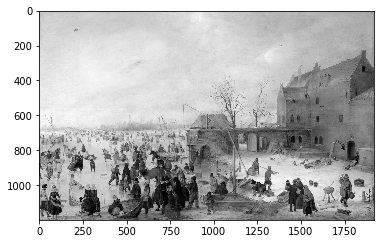

In [23]:
dbt = db + db1
print(dbt)
images = []
imlist = sorted(os.listdir(dbt))

im = db + db1 + 'large (26).jpg'
img = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
img_lab = rgb2lab(img)
img_l = img_lab[:, :, 0]/100.0
    
plt.imshow(img_l, cmap='gray')
plt.show()

In [24]:
# Convert Images
def convert_bw_rgb(im):
    if float(im.shape[0]//H)==im.shape[0]/H:
        a = im.shape[0]
    else:
        a = H*(im.shape[0]//H) + H

    if float(im.shape[1]//W)==im.shape[1]/W:
        b = im.shape[1]
    else:
        b = W*(im.shape[1]//W) + W

    pimg = np.zeros((a, b))
    pimg[0:im.shape[0], 0:im.shape[1]] = im

    new_img = np.zeros((a, b, Ci+Co))
    for j in range(pimg.shape[0]//H):
        print('.', end='')
        for k in range(pimg.shape[1]//W):
            t_l = pimg[j*H:(j+1)*H, k*W:(k+1)*W]

            t_ab = model.predict(t_l.reshape(1, H, W, Ci))
            t_ab = t_ab.reshape(H, W, Co)

            temp = np.zeros((H, W, Ci+Co))
            temp[:, :, 0] = t_l*100.0
            temp[:, :, 1:] = t_ab*128.0
            temp = lab2rgb(temp)

            new_img[j*H:(j+1)*H, k*W:(k+1)*W, :] = temp.reshape(H, W, Ci+Co)

    newimg = np.array(new_img*255, dtype='uint8')
    newimg = newimg[0:im.shape[0], 0:im.shape[1]]
    newimg = cv2.cvtColor(newimg, cv2.COLOR_BGR2RGB)
    
    return newimg

In [25]:
def convert_diff_res(img):
    imres_a, imres_b = [], []
    maxsize = np.max([img.shape[0], img.shape[1]])
    for i in (7, int(np.log2(maxsize))+1):
        dim = np.power(2, i)
        im = cv2.resize(img, (dim, dim), cv2.INTER_LINEAR)
        temp = convert_bw_rgb(im)
        t_lab = rgb2lab(temp)
        t_a = t_lab[:, :, 1]/128.0
        t_b = t_lab[:, :, 2]/128.0
        imres_a.append(t_a)
        imres_b.append(t_b)
    temp = convert_bw_rgb(img)
    cv2.imwrite('Original.jpg', temp)
    t_lab = rgb2lab(temp)
    t_a = t_lab[:, :, 1]/128.0
    t_b = t_lab[:, :, 2]/128.0
    imres_a.append(t_a)
    imres_b.append(t_b)
    return img, imres_a, imres_b

In [26]:
def convert_diff_res_one(imres_l, imres_a, imres_b):
    final_a, final_b = imres_a[0], imres_b[0]
    
    for i in range(len(imres_a)-1):
        final_a = cv2.resize(final_a, (imres_a[i+1].shape[1], imres_a[i+1].shape[0]), cv2.INTER_CUBIC)
        final_b = cv2.resize(final_b, (imres_b[i+1].shape[1], imres_b[i+1].shape[0]), cv2.INTER_CUBIC)
        
        final_a = np.mean([final_a, imres_a[i+1]], axis=0)
        final_b = np.mean([final_b, imres_b[i+1]], axis=0)
        
    fimg = np.zeros((imres_l.shape[0], imres_l.shape[1], 3))
    fimg[:, :, 0] = imres_l*100
    fimg[:, :, 1] = final_a*128
    fimg[:, :, 2] = final_b*128
    
    final = lab2rgb(fimg)
    final = np.array(final*255, dtype='uint8')
    return final

In [27]:
imres_l, imres_a, imres_b = convert_diff_res(img_l)
final = convert_diff_res_one(imres_l, imres_a, imres_b)

...........................

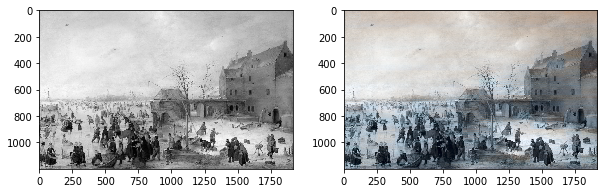

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img_l, cmap='gray')
ax[1].imshow(final)
plt.show()